In [30]:
!pip install -r requirements.txt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import tensorflow as tf
import tensorflow_text as text
import heapq
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

data_path = '../local_data/'

# Data Origin: https://huggingface.co/datasets/OpenCo7/UpVoteWeb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oyka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
columns_to_drop = ['url', 'author', 'kind', 'language', 'language_score', 'media_urls', 'date']

def clean(df):
    df = df.drop(columns=columns_to_drop)
    # df = df[df['score'] > 10]
    df['text'] = df['text'].str.lower()
    return df

In [32]:
working_df = pd.DataFrame()

In [33]:
df = pd.read_parquet(data_path + '0000.parquet')
cleaned_df = clean(df)
working_df = pd.concat([working_df, cleaned_df])

In [34]:
df = pd.read_parquet(data_path + '0001.parquet')
cleaned_df = clean(df)
working_df = pd.concat([working_df, cleaned_df])

In [35]:

working_df.to_parquet(data_path + 'cleaned_df.parquet')

In [36]:
# working_df = pd.read_parquet(data_path + 'cleaned_df.parquet')

In [37]:
working_df.describe()

,score,token_count
count,4.194304e+06,4.194304e+06
mean,1.067672e+01,3.861201e+01
std,8.046946e+01,7.132876e+01
min,-1.537000e+03,0.000000e+00
25%,1.000000e+00,9.000000e+00
50%,2.000000e+00,1.900000e+01
75%,6.000000e+00,4.300000e+01
max,1.896700e+04,3.000000e+04


In [39]:
sample_df = working_df.sample(n=600000, random_state=1234)

print(sample_df.describe())

tokenizer = text.UnicodeScriptTokenizer()

tokenized = tokenizer.tokenize(sample_df['text']).to_list()

               score    token_count
count  600000.000000  600000.000000
mean       10.697337      38.653880
std        81.798644      72.007762
min      -448.000000       1.000000
25%         1.000000       9.000000
50%         2.000000      19.000000
75%         6.000000      43.000000
max     18085.000000   15000.000000


In [40]:
counts = defaultdict(int)

stop_words = set(stopwords.words('english'))

outliers = ['’', 'amp']

for item in tokenized:
    for word in item:
        cur = word.decode('utf-8', errors='ignore')
        if cur in stop_words or cur in string.punctuation or cur in outliers:
            continue
        if cur in counts:
            counts[cur] += 1
        else:
            counts[cur] = 1

min_heap = []

for word, count in counts.items():
    heapq.heappush(min_heap, (count, word))
    if len(min_heap) > 20:
        heapq.heappop(min_heap)

print(min_heap)

min_heap.sort()

for i in range(10):
    print(min_heap[i])

[(23056, 'see'), (23304, 'still'), (23495, 'make'), (30328, 'even'), (23319, 'game'), (24107, 'year'), (27734, 'know'), (33461, 'good'), (31453, 'also'), (25031, 'much'), (34499, 'https'), (46174, 'would'), (48387, 'get'), (28125, 'really'), (50785, 'one'), (34729, 'time'), (35864, 'think'), (35225, '://'), (41340, 'people'), (77451, 'like')]
(23056, 'see')
(23304, 'still')
(23319, 'game')
(23495, 'make')
(24107, 'year')
(25031, 'much')
(27734, 'know')
(28125, 'really')
(30328, 'even')
(31453, 'also')


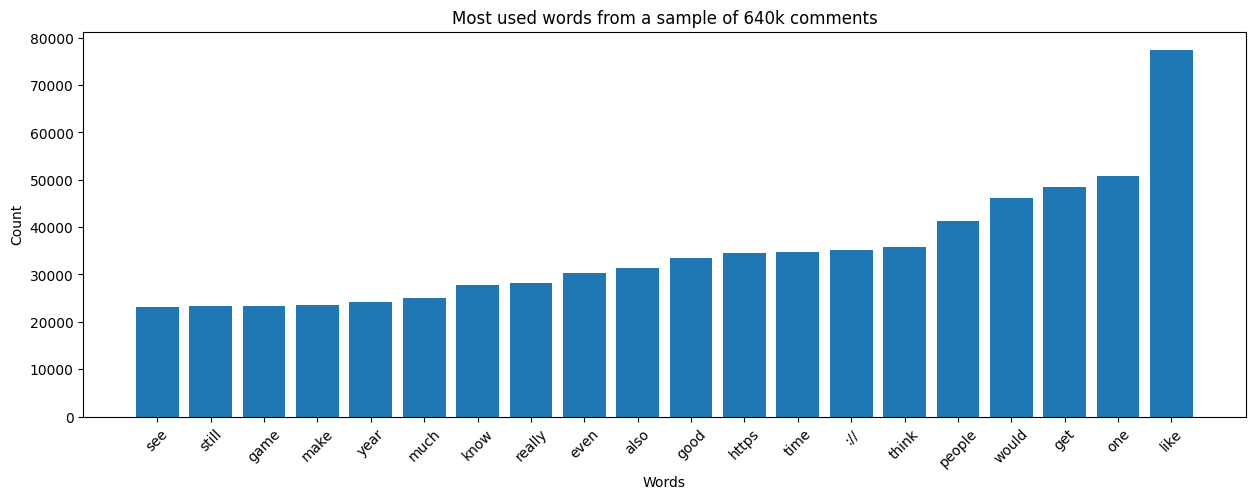

In [41]:
# Draw a bar graph of the most used words
counts, words = zip(*min_heap)
plt.figure(figsize=(15, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most used words from a sample of 640k comments')
plt.show()

In [42]:
subreddits = working_df.groupby('subreddit')

# find the subreddits with the most score per comment
subreddit_score = subreddits['score'].sum() / subreddits['score'].count()

print(subreddit_score.sort_values(ascending=False))

subreddit
kurzgesagt           257.666667
ProWrestlingFeed     206.600000
KimsConvenience      182.000000
AmItheAsshole        168.415179
Fauxmoi               87.213159
                        ...    
chicagomusicscene     -2.800000
Pflugerville          -3.250000
thisismylifenow       -4.000000
waymo                 -9.500000
KamikazeByWords      -11.000000
Name: score, Length: 22990, dtype: float64


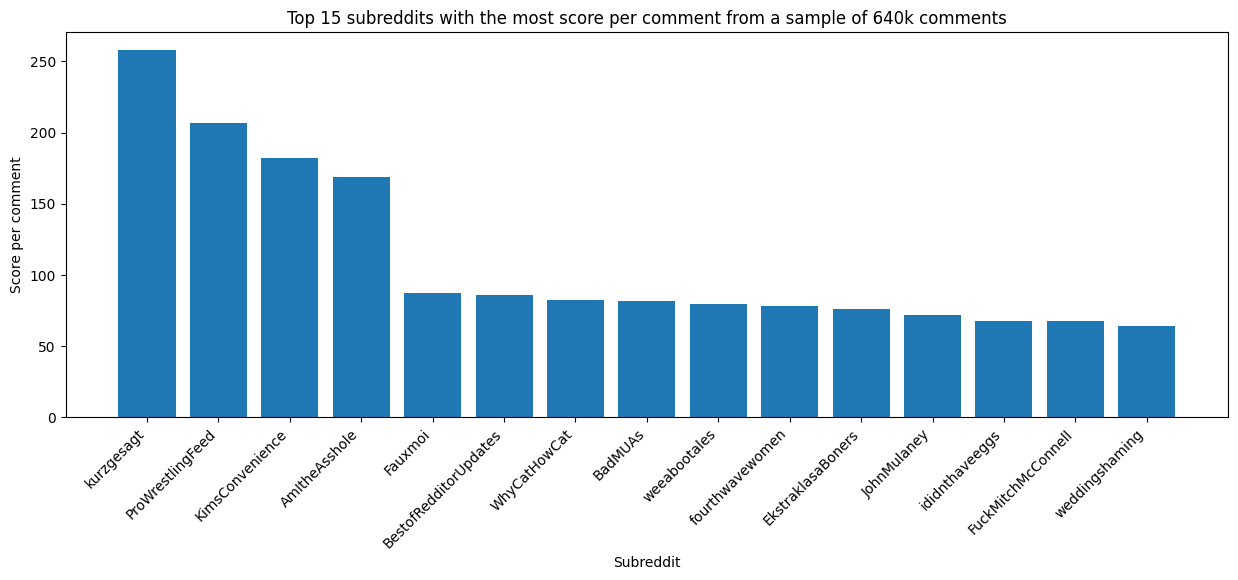

In [44]:
# Draw a bar graph of the top 15 subreddits with the most score per comment
plt.figure(figsize=(15, 5))
plt.bar(subreddit_score.sort_values(ascending=False).head(15).index, subreddit_score.sort_values(ascending=False).head(15))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Subreddit')
plt.ylabel('Score per comment')
plt.title('Top 15 subreddits with the most score per comment from a sample of 640k comments')
plt.show()